In [1]:
%run 'data_preparation.ipynb'

In [2]:
from fbprophet import Prophet

In [3]:
per_day = year.pivot_table(index=['BOOKING_DATE'],values=['BOOKING_HAL_ID'], aggfunc=lambda x: len(x.unique()))

In [4]:
per_day.reset_index(inplace=True)
per_day.tail()

,BOOKING_DATE,BOOKING_HAL_ID
1091,2016-12-27,273
1092,2016-12-28,263
1093,2016-12-29,301
1094,2016-12-30,315
1095,2016-12-31,225


In [5]:
#log-transform as a way to remove some of the anomolies
per_day.BOOKING_HAL_ID = np.log(per_day.BOOKING_HAL_ID)

# Prediction without holiday data

In [58]:
# Prophet requires columns ds (Date) and y (value)
per_day = per_day.rename(columns={'BOOKING_DATE': 'ds', 'BOOKING_HAL_ID': 'y'})
# Make the prophet model and fit on the data
per_day_prophet = Prophet(changepoint_prior_scale=0.15,changepoints=['2014-04-16', '2014-12-17', '2015-01-21', '2015-05-07', '2015-08-20'])
#m = Prophet(weekly_seasonality=False)
per_day_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.2)
per_day_prophet.fit(per_day)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/jawahar/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [59]:
# Make a future dataframe for 2 years
per_day_forecast = per_day_prophet.make_future_dataframe(periods=730, freq='D')
# Make predictions
per_day_forecast = per_day_prophet.predict(per_day_forecast)

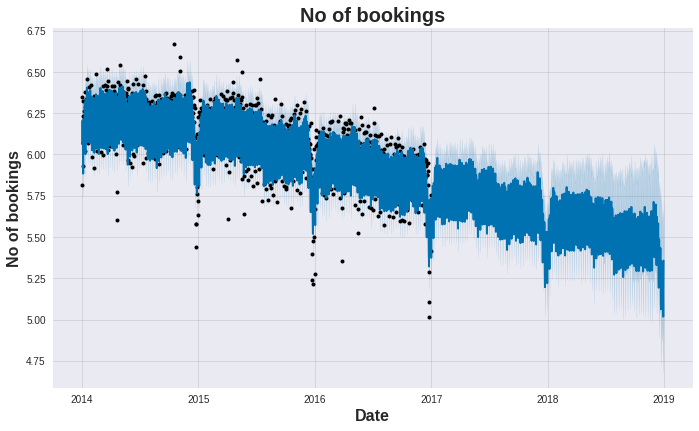

In [60]:
per_day_prophet.plot(per_day_forecast, xlabel = 'Date', ylabel = 'No of bookings')
plt.title('No of bookings');

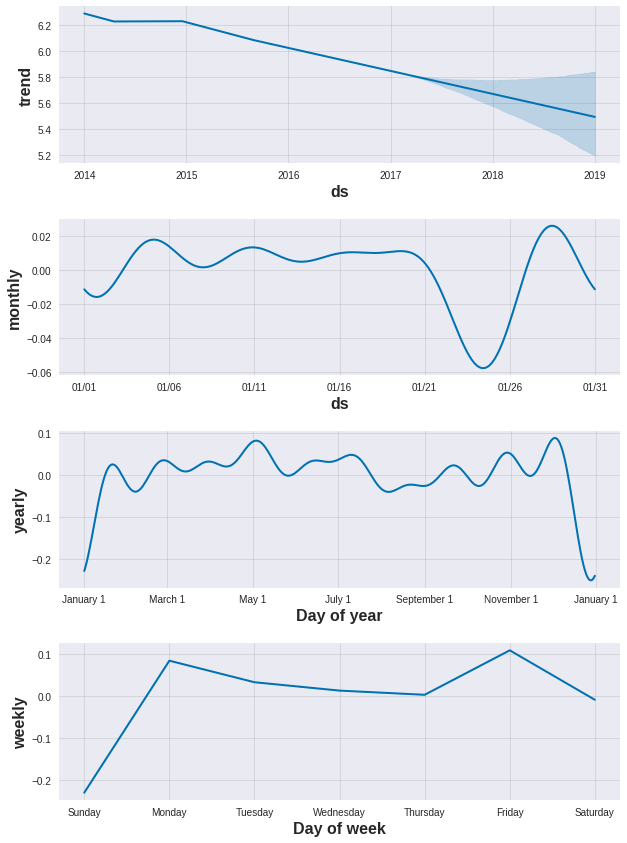

In [61]:
per_day_prophet.plot_components(per_day_forecast);

In [62]:
viz_df = per_day.join(per_day_forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
viz_df['yhat_scaled']=np.exp(viz_df['yhat'])
viz_df['y']=np.exp(viz_df['y'])

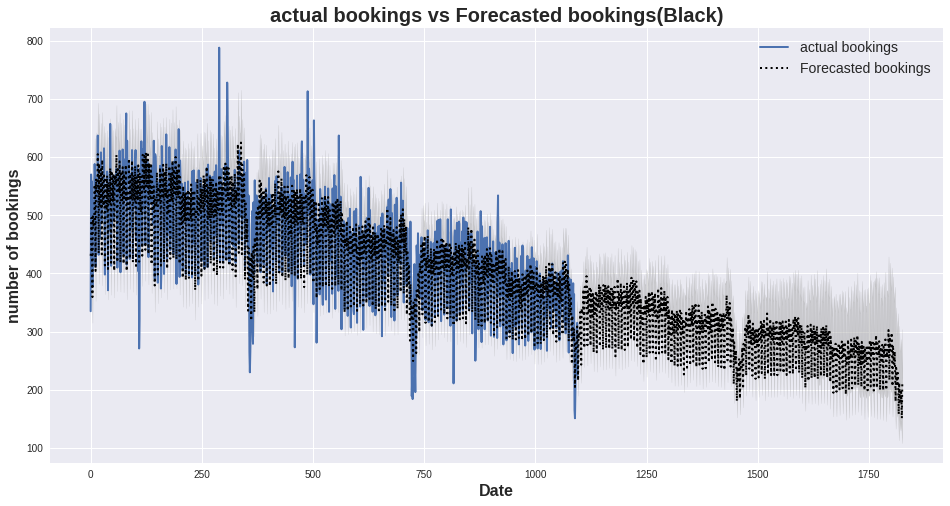

In [63]:
fig, ax1 = plt.subplots()
ax1.plot(viz_df.y)
ax1.plot(viz_df.yhat_scaled, color='black', linestyle=':')
ax1.fill_between(viz_df.index, np.exp(viz_df['yhat_upper']), np.exp(viz_df['yhat_lower']), alpha=0.5, color='darkgray')
ax1.set_title('actual bookings vs Forecasted bookings(Black)')
ax1.set_ylabel('number of bookings')
ax1.set_xlabel('Date')

L=ax1.legend() #get the legend
L.get_texts()[0].set_text('actual bookings') #change the legend text for 1st plot
L.get_texts()[1].set_text('Forecasted bookings') #change the legend text for 2nd plot

In [64]:
per_day_prophet.changepoints

DatetimeIndex(['2014-04-16', '2014-12-17', '2015-01-21', '2015-05-07',
               '2015-08-20'],
              dtype='datetime64[ns]', freq=None)

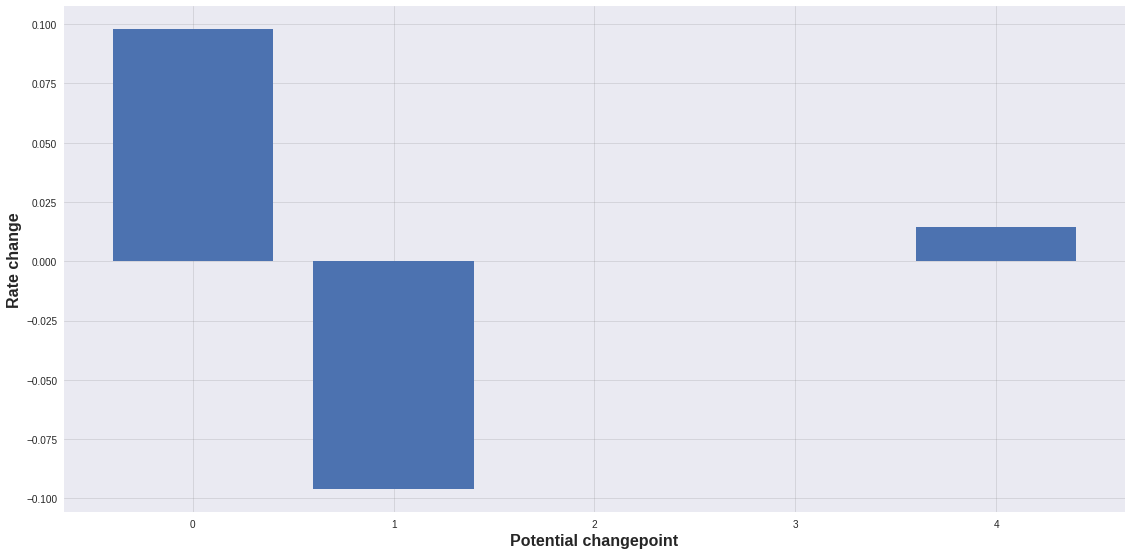

In [65]:
deltas = per_day_prophet.params['delta'].mean(0)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

# Effect of Changepoint Prior Scale

In [178]:
"""# Try 4 different changepoints
for changepoint in [0.001, 0.02, 0.03, 0.04]:
    model = Prophet(daily_seasonality=False, changepoint_prior_scale=changepoint)
    model.fit(per_day)
    
    future = model.make_future_dataframe(periods=12, freq='M')
    future = model.predict(future)
    
    per_day[changepoint] = future['yhat']"""

"# Try 4 different changepoints\nfor changepoint in [0.001, 0.02, 0.03, 0.04]:\n    model = Prophet(daily_seasonality=False, changepoint_prior_scale=changepoint)\n    model.fit(per_day)\n    \n    future = model.make_future_dataframe(periods=12, freq='M')\n    future = model.predict(future)\n    \n    per_day[changepoint] = future['yhat']"

In [179]:
"""plt.figure(figsize=(10, 8))

# Actual observations
plt.plot(per_day['ds'], per_day['y'], 'ko', label = 'Observations')
colors = {0.001: 'b', 0.02: 'r', 0.03: 'green', 0.04: 'gold'}

# Plot each of the changepoint predictions
for changepoint in [0.001, 0.02, 0.03, 0.04]:
    plt.plot(per_day['ds'], per_day[changepoint], color = colors[changepoint], label = '%.3f prior scale' % changepoint)
    
plt.legend(prop={'size': 14})
plt.xlabel('Date'); plt.ylabel('Number of bookings'); plt.title('Effect of Changepoint Prior Scale');"""

"plt.figure(figsize=(10, 8))\n\n# Actual observations\nplt.plot(per_day['ds'], per_day['y'], 'ko', label = 'Observations')\ncolors = {0.001: 'b', 0.02: 'r', 0.03: 'green', 0.04: 'gold'}\n\n# Plot each of the changepoint predictions\nfor changepoint in [0.001, 0.02, 0.03, 0.04]:\n    plt.plot(per_day['ds'], per_day[changepoint], color = colors[changepoint], label = '%.3f prior scale' % changepoint)\n    \nplt.legend(prop={'size': 14})\nplt.xlabel('Date'); plt.ylabel('Number of bookings'); plt.title('Effect of Changepoint Prior Scale');"

# Prediction with holiday data

In [66]:
holidays = pd.DataFrame({
  'holiday': 'school-holidays',
  'ds': schoolholidays.Bayern,
  'lower_window': 0,
  'upper_window': 0,
});

In [67]:
holidays.head()

,ds,holiday,lower_window,upper_window
0,2014-01-01,school-holidays,0,0
1,2014-01-02,school-holidays,0,0
2,2014-01-03,school-holidays,0,0
3,2014-01-04,school-holidays,0,0
4,2014-01-06,school-holidays,0,0


In [68]:
model = Prophet(holidays=holidays, changepoint_prior_scale=0.15,changepoints=['2014-04-16', '2014-12-17', '2015-01-21', '2015-05-07', '2015-08-20'])
model.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.1);

In [69]:
model.fit(per_day)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/jawahar/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [70]:
future = model.make_future_dataframe(periods=730, freq = 'D')
future.tail()

,ds
1821,2018-12-27
1822,2018-12-28
1823,2018-12-29
1824,2018-12-30
1825,2018-12-31


In [71]:
forecast = model.predict(future)

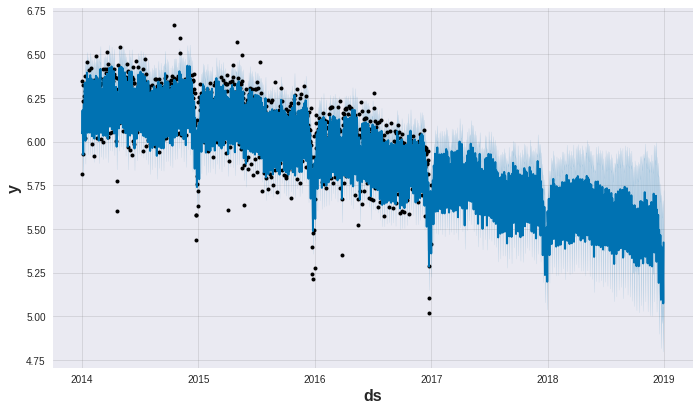

In [72]:
model.plot(forecast);

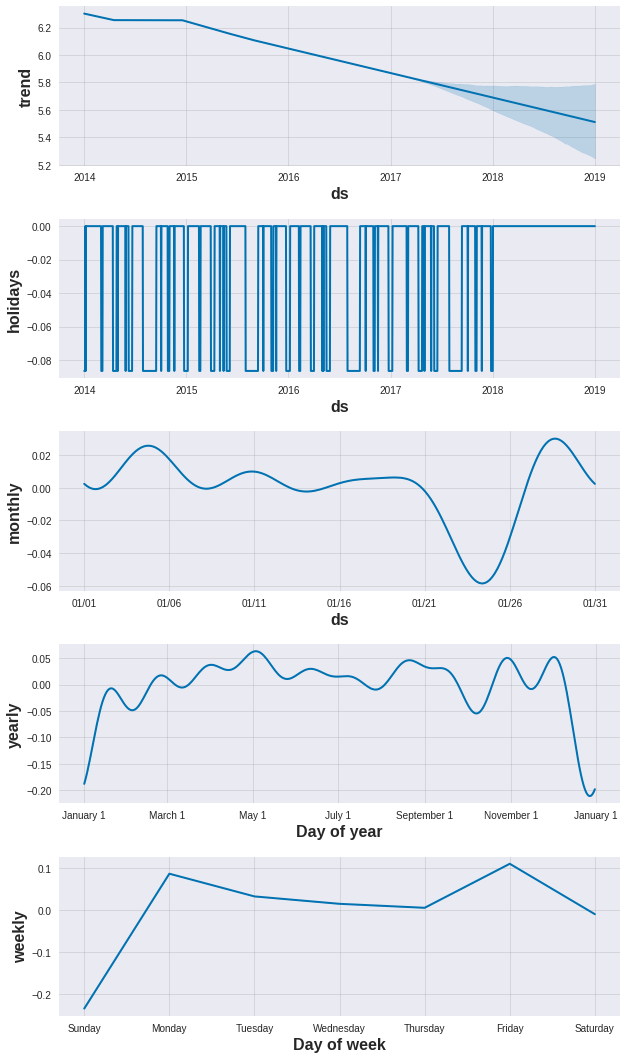

In [73]:
model.plot_components(forecast);

In [74]:
hviz_df = per_day.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')

In [75]:
hviz_df['yhat_scaled']=np.exp(hviz_df['yhat'])
hviz_df['y']=np.exp(hviz_df['y'])

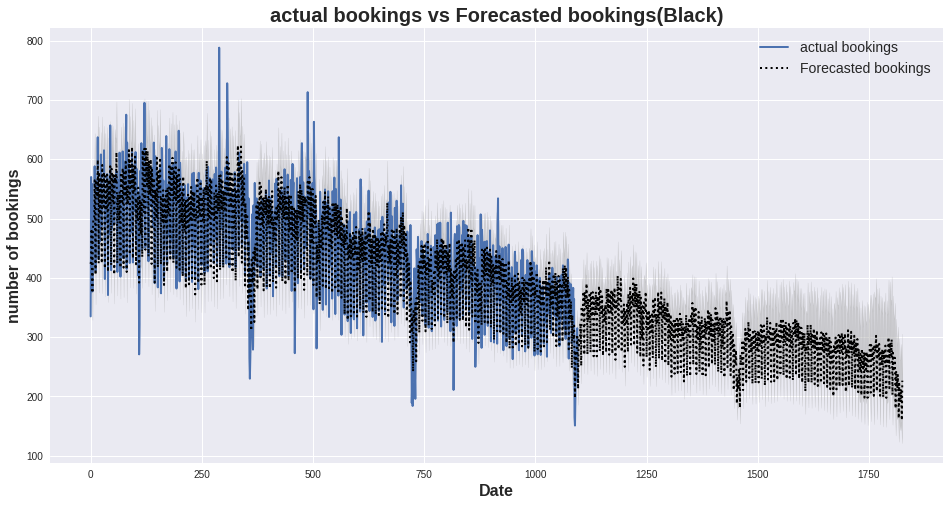

In [76]:
fig, ax1 = plt.subplots()
ax1.plot(hviz_df.y)
ax1.plot(hviz_df.yhat_scaled, color='black', linestyle=':')
ax1.fill_between(hviz_df.index, np.exp(hviz_df['yhat_upper']), np.exp(hviz_df['yhat_lower']), alpha=0.5, color='darkgray')
ax1.set_title('actual bookings vs Forecasted bookings(Black)')
ax1.set_ylabel('number of bookings')
ax1.set_xlabel('Date')

L=ax1.legend() #get the legend
L.get_texts()[0].set_text('actual bookings') #change the legend text for 1st plot
L.get_texts()[1].set_text('Forecasted bookings') #change the legend text for 2nd plot

# changepoints

In [77]:
model.changepoints

DatetimeIndex(['2014-04-16', '2014-12-17', '2015-01-21', '2015-05-07',
               '2015-08-20'],
              dtype='datetime64[ns]', freq=None)

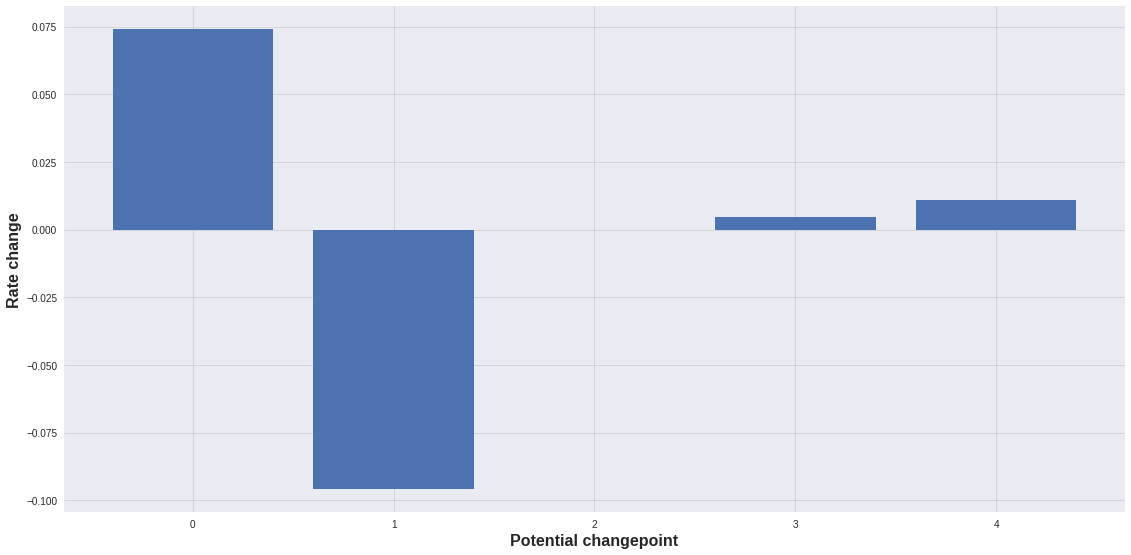

In [78]:
deltas = model.params['delta'].mean(0)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
fig.tight_layout()

# Difference between holiday and non-holiday

In [79]:
forecast.tail()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,holidays,holidays_lower,holidays_upper,monthly,...,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
1821,2018-12-27,5.513363,5.251597,5.788313,4.962572,5.571041,0.0,0.0,0.0,-0.057740,...,-0.263897,-0.263897,-0.263897,0.004667,0.004667,0.004667,-0.210824,-0.210824,-0.210824,5.249467
1822,2018-12-28,5.512874,5.250345,5.788839,5.056984,5.665045,0.0,0.0,0.0,-0.052652,...,-0.154345,-0.154345,-0.154345,0.109444,0.109444,0.109444,-0.211136,-0.211136,-0.211136,5.358530
1823,2018-12-29,5.512385,5.249092,5.789365,4.973299,5.581104,0.0,0.0,0.0,-0.028023,...,-0.247953,-0.247953,-0.247953,-0.010565,-0.010565,-0.010565,-0.209365,-0.209365,-0.209365,5.264432
1824,2018-12-30,5.511896,5.247839,5.789890,4.799939,5.374787,0.0,0.0,0.0,0.003947,...,-0.436859,-0.436859,-0.436859,-0.235229,-0.235229,-0.235229,-0.205578,-0.205578,-0.205578,5.075036
1825,2018-12-31,5.511407,5.246587,5.790416,5.131775,5.722947,0.0,0.0,0.0,0.026116,...,-0.087951,-0.087951,-0.087951,0.085813,0.085813,0.085813,-0.199880,-0.199880,-0.199880,5.423456


In [80]:
#forecast.set_index('ds', inplace=True)
#per_day_forecast.set_index('ds', inplace=True)
compared_df = forecast.join(per_day_forecast, rsuffix="_no_holiday")

In [93]:
compared_df = compared_df[['yhat', 'yhat_no_holiday']]

In [94]:
compared_df.head()

,yhat,yhat_no_holiday
0,6.048535,6.064567
1,6.060213,6.079816
2,6.179172,6.205581
3,6.063371,6.098427
4,5.925774,5.884259


In [95]:
compared_dfexp= compared_df[['yhat', 'yhat_no_holiday']]

In [96]:
compared_dfexp['diff_per'] = 100*(compared_dfexp['yhat'] - compared_dfexp['yhat_no_holiday']) / compared_dfexp['yhat_no_holiday']

In [97]:
compared_dfexp.tail()

,yhat,yhat_no_holiday,diff_per
1821,5.249467,5.191120,1.123979
1822,5.358530,5.298234,1.138027
1823,5.264432,5.204768,1.146332
1824,5.075036,5.017595,1.144797
1825,5.423456,5.357426,1.232493


In [98]:
compared_dfexp['diff_per'].mean()

0.06793764159652872

In [99]:
final_df= pd.DataFrame(compared_df)

In [100]:
final_df.head()

,yhat,yhat_no_holiday
0,6.048535,6.064567
1,6.060213,6.079816
2,6.179172,6.205581
3,6.063371,6.098427
4,5.925774,5.884259


In [101]:
per_day.head()

,ds,y
0,2014-01-01,5.814131
1,2014-01-02,6.345636
2,2014-01-03,6.234411
3,2014-01-04,6.324359
4,2014-01-05,5.932245


In [106]:
result_df = per_day.join(final_df, rsuffix="del")

In [107]:
result_df = result_df.rename(columns={'ds':'BOOKING_DATE','y':'BOOKING_HAL_ID'})

In [108]:
result_df['BOOKING_HAL_ID']= np.exp(result_df['BOOKING_HAL_ID'])
result_df['yhat']= np.exp(result_df['yhat'])
result_df['yhat_no_holiday']= np.exp(result_df['yhat_no_holiday'])

In [109]:
cols = ['BOOKING_HAL_ID','yhat', 'yhat_no_holiday']
result_df[cols] = result_df[cols].applymap(np.int64)

In [111]:
result_df.head()

,BOOKING_DATE,BOOKING_HAL_ID,yhat,yhat_no_holiday
0,2014-01-01,334,423,430
1,2014-01-02,570,428,436
2,2014-01-03,509,482,495
3,2014-01-04,557,429,445
4,2014-01-05,377,374,359


# Measuring the accuracy of the FbProphet model

In [121]:
#using sklearn metrics

In [118]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [113]:
r2_score(result_df.BOOKING_HAL_ID, result_df.yhat)

0.7734676479827517

In [114]:
mean_squared_error(result_df.BOOKING_HAL_ID, result_df.yhat)

1724.537408759124

In [117]:
mean_absolute_error(result_df.BOOKING_HAL_ID, result_df.yhat)

30.577554744525546

In [122]:
#using ml metrics

In [120]:
import ml_metrics as metrics

In [124]:
metrics.mae(result_df.BOOKING_HAL_ID, result_df.yhat)

30.577554744525546

In [126]:
metrics.ae(result_df.BOOKING_HAL_ID, result_df.yhat)

array([ 89, 142,  27, ...,  28,  11,  43])

In [127]:
metrics.rmse(result_df.BOOKING_HAL_ID, result_df.yhat)

41.527549997069706

In [ ]:
#with out holiday data

In [128]:
metrics.rmse(result_df.BOOKING_HAL_ID, result_df.yhat_no_holiday)

42.85360625831933

In [125]:
#interactive plotting with plotly

In [168]:
trace0 = go.Scatter(
    x = result_df.BOOKING_DATE,
    y = result_df.BOOKING_HAL_ID,
    mode = 'lines',
    name = 'actual number of bookings'
)
trace1 = go.Scatter(
    x = result_df.BOOKING_DATE,
    y = result_df.yhat,
    mode = 'lines',
    name = 'number of bookings with holiday data'
)
trace2 = go.Scatter(
    x = result_df.BOOKING_DATE,
    y = result_df.yhat_no_holiday,
    mode = 'lines',
    name = 'number of bookings with out holiday data'
)
layout = go.Layout(title="observations from FbProphet model",
                yaxis=dict(title='number of bookings')
                )
fig = go.Figure(data=[trace0, trace1, trace2], layout=layout)
py.iplot(fig, filename="Observations from FbProphet")

In [169]:
trace0 = go.Scatter(
    x = result_df.BOOKING_DATE,
    y = result_df.BOOKING_HAL_ID,
    mode = 'lines',
    name = 'actual number of bookings'
)
trace1 = go.Scatter(
    x = compared_df.ds,
    y = compared_df.yhat,
    mode = 'lines',
    name = 'number of bookings with holiday data'
)
trace2 = go.Scatter(
    x = compared_df.ds,
    y = compared_df.yhat_no_holiday,
    mode = 'lines',
    name = 'number of bookings with out holiday data'
)
layout = go.Layout(title="observations from FbProphet model with next 2 years prediction",
                yaxis=dict(title='number of bookings')
                )
fig = go.Figure(data=[trace0, trace1, trace2], layout=layout)
py.iplot(fig, filename="Observations from FbProphet")

# Observations

# RMSE values for the model

model with holidays data

Model without holidays data